In [1]:
import json
import os
import time
import warnings

import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pysam
import pyfaidx
import tensorflow as tf

from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna

from borzoi_helpers import *

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2023-09-26 19:11:42.111709: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 19:11:45.658475: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%%bash

#Download model weights
for fold in f0 f1 f2 f3; do
  mkdir -p "saved_models/$fold/"
  local_model="saved_models/$fold/model0_best.h5"
  if [ -f "$local_model" ]; then
    echo "$fold model already exists."
  else
    wget --progress=bar:force "https://storage.googleapis.com/seqnn-share/borzoi/$fold/model0_best.h5" -O "$local_model"
  fi
done

#Download and uncompress annotation files
if [ -f gencode41_basic_nort.gtf ]; then
  echo "Annotation already exists."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_nort.gtf.gz | gunzip -c > gencode41_basic_nort.gtf
fi
if [ -f gencode41_basic_protein_splice.csv.gz ]; then
  echo "Splice sites already exist."
else
  wget https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein_splice.csv.gz
fi
if [ -f polyadb_human_v3.csv.gz ]; then
  echo "PolyA sites already exist."
else
  wget https://storage.googleapis.com/seqnn-share/helper/polyadb_human_v3.csv.gz
fi

#Download and index hg38 genome
if [ -f hg38.fa ]; then
  echo "Human genome FASTA already exists."
else
  wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > hg38.fa
fi

bash: /home/jlinder/anaconda3/envs/borzoi_py39_2/lib/libtinfo.so.6: no version information available (required by bash)


f0 model already exists.
f1 model already exists.
f2 model already exists.
f3 model already exists.
Annotation already exists.
Splice sites already exist.
PolyA sites already exist.
Human genome FASTA already exists.


In [3]:
pyfaidx.Faidx('hg38.fa')

Faidx("hg38.fa")

In [4]:
#Model configuration

params_file = 'params_pred.json'
targets_file = 'targets_gtex.txt' #Subset of targets_human.txt

seq_len = 524288
n_folds = 1       #To use only one model fold, set to 'n_folds = 1'. To use all four folds, set 'n_folds = 4'.
rc = True         #Average across reverse-complement prediction

#Read model parameters

with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

#Read targets

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

#Create local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = targets_df.strand_pair
    
    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')

#Initialize model ensemble

models = []
for fold_ix in range(n_folds) :
    
    model_file = "saved_models/f" + str(fold_ix) + "/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, '0')
    
    models.append(seqnn_model)


2023-09-26 19:11:59.651232: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10372 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:81:00.0, compute capability: 6.1


In [5]:
#Initialize fasta sequence extractor

fasta_open = pysam.Fastafile('hg38.fa')

#Load splice site annotation

splice_df = pd.read_csv('gencode41_basic_protein_splice.csv.gz', sep='\t', compression='gzip')

print("len(splice_df) = " + str(len(splice_df)))


len(splice_df) = 404837


In [6]:
#Print index of GTEx testis tracks in targets file

targets_df['local_index'] = np.arange(len(targets_df))

print("testis tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:testis']['local_index'].tolist()))


testis tracks = [79, 80]


2023-09-26 19:13:40.227238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-09-26 19:13:40.745579: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


-- Counts --
 - max_y_wt = 60.267
 - max_y_mut = 60.4653
 -- (max_y = 60.4653)


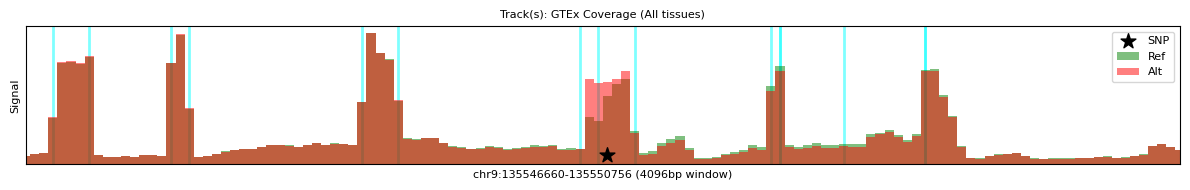

 - max_y_wt = 361.0789
 - max_y_mut = 360.6328
 -- (max_y = 361.0789)


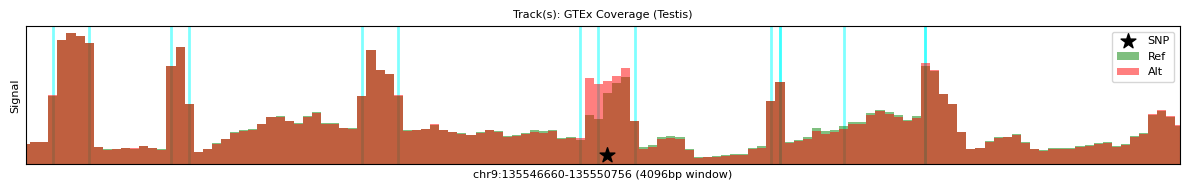

CPU times: user 13.1 s, sys: 716 ms, total: 13.9 s
Wall time: 16.3 s


In [7]:
%%time
#Predict for chr9_135548708_G_C
# (~6 minutes on CPU w 1 fold; ~15 seconds on GPU)

save_figs = False
save_suffix = '_chr9_135548708_G_C'

center_pos = 135548708

chrom = 'chr9'
poses = [135548708]
alts = ['C']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

sequence_one_hot_wt = process_sequence(fasta_open, chrom, start, end)

#Induce mutation(s)
sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

for pos, alt in zip(poses, alts) :
    alt_ix = -1
    if alt == 'A' :
        alt_ix = 0
    elif alt == 'C' :
        alt_ix = 1
    elif alt == 'G' :
        alt_ix = 2
    elif alt == 'T' :
        alt_ix = 3

    sequence_one_hot_mut[pos-start-1] = 0.
    sequence_one_hot_mut[pos-start-1, alt_ix] = 1.

#Make predictions
y_wt = predict_tracks(models, sequence_one_hot_wt)
y_mut = predict_tracks(models, sequence_one_hot_mut)

#Visualize quantized tracks over SNP

plot_window = 4096
bin_size = 32
pad = 16

rescale_tracks = True
normalize_counts = False

anno_df = splice_df

#Tracks
track_indices = [
    np.arange(0, 89).tolist(),
    [79, 80],
]

track_names = [
    'GTEx Coverage (All tissues)',
    'GTEx Coverage (Testis)',
]

track_scales = [0.01]*2
track_transforms = [3./4.]*2
soft_clips = [384.]*2

print("-- Counts --")
plot_coverage_track_pair_bins(
    y_wt,
    y_mut,
    chrom,
    start,
    center_pos,
    poses,
    track_indices,
    track_names,
    track_scales,
    track_transforms,
    soft_clips,
    plot_window=plot_window,
    normalize_window=8*plot_window,
    bin_size=bin_size,
    pad=pad,
    rescale_tracks=rescale_tracks,
    normalize_counts=normalize_counts,
    save_figs=save_figs,
    save_suffix=save_suffix,
    anno_df=anno_df
)


In [8]:
#Print splice site bin positions and other info

plot_start = center_pos - plot_window // 2
plot_end = center_pos + plot_window // 2

plot_start_bin = (plot_start - start) // bin_size - pad
plot_end_bin = (plot_end - start) // bin_size - pad

mut_bin = (poses[0] - start) // bin_size - pad

#Get splice site positions
splice_poses = splice_df.query("chrom == '" + chrom + "' and position_hg38 >= " + str(plot_start) + " and position_hg38 < " + str(plot_end))['position_hg38'].unique().tolist()

print("mut_bin = " + str(mut_bin))
print("")

#Print splice site positions
for splice_ix, splice_pos in enumerate(splice_poses) :
    
    splice_bin = int((splice_pos - start) // 32) - 16
    
    bin_end = splice_bin + 3
    bin_start = bin_end - 5
    
    print("splice_ix = " + str(splice_ix) + ": bin = " + str(splice_bin) + " (" + str(bin_start) + " - " + str(bin_end) + ")")


mut_bin = 8176

splice_ix = 0: bin = 8115 (8113 - 8118)
splice_ix = 1: bin = 8119 (8117 - 8122)
splice_ix = 2: bin = 8128 (8126 - 8131)
splice_ix = 3: bin = 8130 (8128 - 8133)
splice_ix = 4: bin = 8149 (8147 - 8152)
splice_ix = 5: bin = 8153 (8151 - 8156)
splice_ix = 6: bin = 8173 (8171 - 8176)
splice_ix = 7: bin = 8175 (8173 - 8178)
splice_ix = 8: bin = 8179 (8177 - 8182)
splice_ix = 9: bin = 8194 (8192 - 8197)
splice_ix = 10: bin = 8195 (8193 - 8198)
splice_ix = 11: bin = 8195 (8193 - 8198)
splice_ix = 12: bin = 8202 (8200 - 8205)
splice_ix = 13: bin = 8211 (8209 - 8214)
splice_ix = 14: bin = 8211 (8209 - 8214)


In [9]:
#Choose splice sites to use for attributions

exon_1_start_bin = 8173
exon_1_end_bin = 8176

exon_2_start_bin = 8180
exon_2_end_bin = 8183


In [10]:
%%time
#Get contribution scores (gradient) for testis GTEX tracks
# (~20 minutes on CPU; otherwise runnable only on 40GB GPU cards, e.g. A100)

_, _, [pred_grad_wt, pred_grad_mut] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    exon_2_start_bin,
    exon_2_end_bin,
    exon_1_start_bin,
    exon_1_end_bin,
    target_index[[79, 80]].tolist(),
    0.01,
    3./4.,
    clip_soft=384.,
    use_mean=False,
    use_ratio=True,
    use_logodds=False,
    subtract_avg=True,
    fold_index=np.arange(n_folds).tolist(),
)


1/1 [==============================] - 220s 220s/step
CPU times: user 18min 44s, sys: 2min 45s, total: 21min 30s
Wall time: 22min 55s


--- WT ---


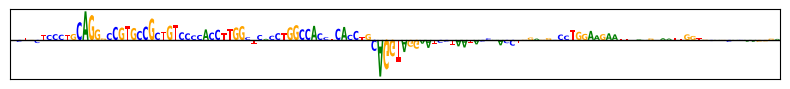

--- Mut ---


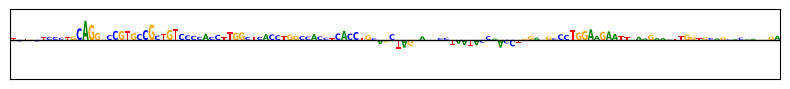

In [11]:
#Visualize gradient contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_grad_wt,
    pred_grad_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_grad_gtex_snp_4_folds_gtex_cov_testis_undo_clip'
)


In [12]:
%%time
#Get contribution scores (ISM) for testis GTEX tracks
# (not feasible to run on CPU; ~30 minutes on GPU)

[pred_ism_wt, pred_ism_mut] = get_ism(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (poses[0] - start) - 64,
    (poses[0] - start) + 64,
    exon_2_start_bin,
    exon_2_end_bin,
    exon_1_start_bin,
    exon_1_end_bin,
    [79, 80],
    0.01,
    3./4.,
    384.,
    use_mean=False,
    use_ratio=True,
    use_logodds=False
)


example_ix = 0
example_ix = 1
CPU times: user 15min 37s, sys: 1min 15s, total: 16min 53s
Wall time: 33min 18s


--- WT ---


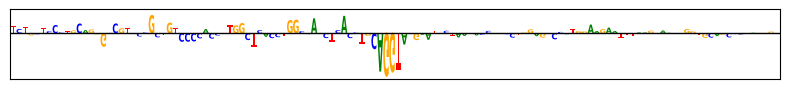

--- Mut ---


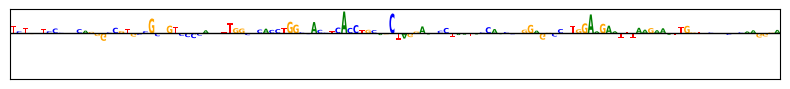

In [13]:
#Visualize ISM contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_gtex_snp_4_folds_gtex_cov_testis_undo_clip'
)


In [14]:
%%time
#Get contribution scores (ISM shuffle) for testis GTEX tracks
# (not feasible to run on CPU; ~135 minutes on GPU)

[pred_ism_wt, pred_ism_mut] = get_ism_shuffle(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    (poses[0] - start) - 64,
    (poses[0] - start) + 64,
    exon_2_start_bin,
    exon_2_end_bin,
    exon_1_start_bin,
    exon_1_end_bin,
    [79, 80],
    0.01,
    3./4.,
    384.,
    window_size=5,
    n_samples=12,
    use_mean=False,
    use_ratio=True,
    use_logodds=False
)


example_ix = 0
example_ix = 1
CPU times: user 1h 2min, sys: 5min 17s, total: 1h 7min 17s
Wall time: 2h 13min 1s


--- WT ---


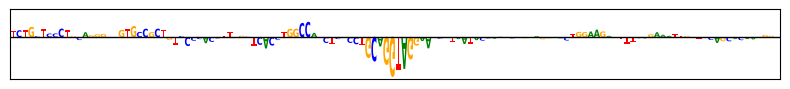

--- Mut ---


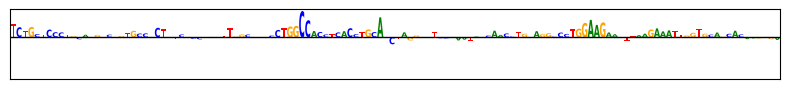

In [15]:
#Visualize ISM Shuffle contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_shuffle_gtex_snp_4_folds_gtex_cov_testis_undo_clip'
)


In [16]:
#Load samples with reference- and alternate alleles respectively

#These files are protected by dbGaP - email to request access

cov_files_wt = pd.read_csv("gtex_ref_chr9_135548708_G_C.txt", sep='\t', names=['file'])['file'].values.tolist()
cov_files_mut = pd.read_csv("gtex_alt_chr9_135548708_G_C.txt", sep='\t', names=['file'])['file'].values.tolist()


gtex_targets_wt.shape = (16352, 5)
gtex_targets_mut.shape = (16352, 5)
-- Counts --
 - max_y_wt = 986.4816
 - max_y_mut = 1083.784
 -- (max_y = 1083.784)


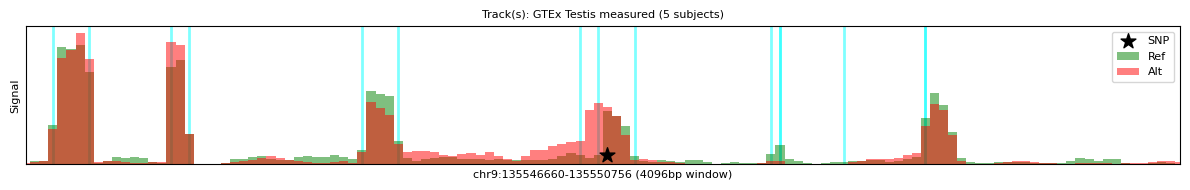

In [17]:
#Read measured coverage tracks for chr9_135548708_G_C

save_figs = False
save_suffix = '_chr9_135548708_G_C_meas_5_subjects'

center_pos = 135548708

chrom = 'chr9'
poses = [135548708]
alts = ['C']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

blacklist_bed = "/home/drk/common/data/genomes/hg38/blacklist/blacklist_hg38_all.bed"

read_coverage_func_wt, close_coverage_func_wt = get_coverage_reader(cov_files_wt, 16384, 16, blacklist_bed)
read_coverage_func_mut, close_coverage_func_mut = get_coverage_reader(cov_files_mut, 16384, 16, blacklist_bed)

gtex_targets_wt = read_coverage_func_wt(chrom, start, end, clip_soft=384., clip=768., scale=0.01)
gtex_targets_mut = read_coverage_func_mut(chrom, start, end, clip_soft=384., clip=768., scale=0.01)

close_coverage_func_wt()
close_coverage_func_mut()

print("gtex_targets_wt.shape = " + str(gtex_targets_wt.shape))
print("gtex_targets_mut.shape = " + str(gtex_targets_mut.shape))

plot_window = 4096
bin_size = 32
pad = 16

anno_df = splice_df

rescale_tracks = True
normalize_counts = True

#Tracks
track_indices = [
    [0, 1, 2, 3, 4],
]

track_names = [
    'GTEx Testis measured (5 subjects)',
]

track_scales = [
    0.01,
]

track_transforms = [
    3./4.,
]

soft_clips = [
    384.,
]

print("-- Counts --")
plot_coverage_track_pair_bins(
    gtex_targets_wt[None, None, ...],
    gtex_targets_mut[None, None, ...],
    chrom,
    start,
    center_pos,
    poses,
    track_indices,
    track_names,
    track_scales,
    track_transforms,
    soft_clips,
    plot_window=plot_window,
    normalize_window=8*plot_window,
    bin_size=bin_size,
    pad=pad,
    rescale_tracks=rescale_tracks,
    normalize_counts=normalize_counts,
    save_figs=save_figs,
    save_suffix=save_suffix,
    anno_df=anno_df
)
